## Tech Preamble

In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Reshape, Flatten, \
  LeakyReLU, Activation, Dropout, Concatenate, BatchNormalization, \
  ConvLSTM2D, ZeroPadding2D, Cropping2D, RepeatVector
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import metrics, losses

from sklearn.model_selection import train_test_split


import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import os
os.chdir("/content/drive/MyDrive/data_exchange/")

Mounted at /content/drive


In [3]:
dataset = np.load('pv4.npy')[::50,]

In [4]:
dataset.shape

(2000, 64, 64, 1)

## pre-process data

In [5]:
def norm_train(x,min_x,max_x):
  return 2*(x-min_x)/(max_x-min_x)-1
  #-1 1

def norm_out(x,min_x,max_x):
  return (x-min_x)/(max_x-min_x)
  #0 1

In [6]:
# normalize data
dataset_x =norm_train(dataset,dataset.min(),dataset.max())
dataset_y =norm_out(dataset,dataset.min(),dataset.max())

# split train/val/test
x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.15)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.05)

In [7]:
#x_train.shape

# setup Unet

In [8]:
# define the encoder block
def convolution_block(layer_in, n_filters, kernel_size, stride, batchnorm=True):

  # weight initialization
	init = tf.random_normal_initializer(0., 0.02)

 ## Was macht der initilizer?

  # add downsampling layer
	g = Conv2D(n_filters, kernel_size=kernel_size, strides=stride, padding='same',
            kernel_initializer=init, use_bias=False)(layer_in)

## so no pooling?

  # conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g)#, training=True)
	# leaky relu activation
	g = Activation('tanh')(g)
	return g

# define the decoder block
def deconvolution_concat_block(layer_in, skip_in, n_filters, kernel_size, stride, cropping, dropout=True):

  # weight initialization
	init = tf.random_normal_initializer(0., 0.02)

  # add upsampling layer
	g = Conv2DTranspose(n_filters, kernel_size=kernel_size, strides=stride, padding='same',
                     kernel_initializer=init, use_bias=False)(layer_in)
	# add cropping
	g = Cropping2D(cropping=cropping)(g)

  # add batch normalization
	g = BatchNormalization()(g)#, training=True)

	# conditionally add dropout
	if dropout:
		g = Dropout(0.05)(g)#, training=True)

  # relu activation
	g = Activation('tanh')(g)

  # merge with skip connection

#are these the horizontal lines?

	g = Concatenate()([g, skip_in])
	#lm = ConvLSTM2D(256, (2,2), padding='same', return_sequences=True,
	#                dropout=0.2, recurrent_dropout=0.2)(skip_in, training=True)
	#g = Concatenate()([g, lm])

	return g

# define the decoder block
def deconvolution_block(layer_in, n_filters, kernel_size, stride, cropping, dropout=True):

  # weight initialization
	init = tf.random_normal_initializer(0., 0.02)

  # add upsampling layer
	g = Conv2DTranspose(n_filters, kernel_size=kernel_size, strides=stride, padding='same',
                     kernel_initializer=init, use_bias=False)(layer_in)
	# add cropping
	g = Cropping2D(cropping=cropping)(g)

  # add batch normalization
	g = BatchNormalization()(g)#, training=True)

  # relu activation
	g = Activation('tanh')(g)

	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g)#, training=True)

	return g


In [9]:
s = 4 #stencil size

In [10]:

# define the standalone generator model
def define_generator(image_shape):

  # weight initialization
	init = tf.random_normal_initializer(0., 0.02)

  # image input
	in_image = Input(shape=image_shape)

  # encoder model:
	e1 = convolution_block(in_image, 16, (s,s), (2,2), batchnorm=False)
 	# e1 = Concatenate(axis=1)([e1, e1, e1, e1])

	e2 = convolution_block(e1, 32, (s,s), (2,2))
	e3 = convolution_block(e2, 64, (s,s), (2,2))
	e4 = convolution_block(e3, 128, (s,s), (2,2))
	e5 = convolution_block(e4, 128, (s,s), (2,2))
	e6 = convolution_block(e5, 256, (s,s), (2,2))
	b = convolution_block(e6, 256, (s,s), (1,1))

#Why no bottleneck?

	# bottleneck LSTM
	#b = ConvLSTM2D(256, (2,2), padding='same', return_sequences=True,
	#               dropout=0.2, recurrent_dropout=0.2)(b, training=True)
	#b = ConvLSTM2D(256, (2,2), padding='same', return_sequences=True,
	#               dropout=0.2, recurrent_dropout=0.2)(b, training=True)

  # decoder model:
	d1 = deconvolution_concat_block(b, e6, 256, (s,s), (1,1), ((0,0),(0,0)))
	d2 = deconvolution_concat_block(d1, e5, 128, (s,s), (2,2), ((0,0),(0,0)))

	d3 = deconvolution_concat_block(d2, e4, 128, (s,s), (2,2), ((0,0),(0,0)))
	d4 = deconvolution_concat_block(d3, e3, 64, (s,s), (2,2), ((0,0),(0,0)))
	d5 = deconvolution_concat_block(d4, e2, 32, (s,s), (2,2), ((0,0),(0,0)))
	d6 = deconvolution_concat_block(d5, e1, 16, (s,s), (2,2), ((0,0),(0,0)), dropout=False)
	d6 = deconvolution_block(d6, 16, (s,s), (1,1), ((0,0),(0,0)), dropout=False)
	d6 = deconvolution_block(d6, 16, (s,s), (1,1), ((0,0),(0,0)), dropout=False)

  # # output
	out_image = Conv2DTranspose(1, 4, strides=2, padding='same',
                     kernel_initializer=init)(d6)

	out_image = Activation('linear')(out_image)

  # define model
	model = Model(in_image, out_image)

	return model



In [11]:
input_shape=(64, 64, 1)
output_shape=(64, 64, 1)

generator=define_generator(input_shape)
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 16)     │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 16)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 32)     │          8,192 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 16, 16, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 64)       │         32,768 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 8, 8, 64)       │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 8, 8, 64)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 4, 4, 128)      │        131,072 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 4, 4, 128)      │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 4, 4, 128)      │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 2, 2, 128)      │        262,144 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 2, 2, 128)      │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 2, 2, 128)      │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 1, 1, 256)      │        524,288 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 1, 1, 256)      │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 4,991,425 (19.04 MB)

 Trainable params: 4,988,385 (19.03 MB)

 Non-trainable params: 3,040 (11.88 KB)

In [12]:
generator.compile(optimizer='adam',loss='mse')

# train unet

Epoch 1/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 0.2229 - val_loss: 0.1772
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 0.0369 - val_loss: 0.0870
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0061 - val_loss: 0.0665
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 0.0038 - val_loss: 0.0520
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 0.0030 - val_loss: 0.0389
Epoch 6/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0024 - val_loss: 0.0295
Epoch 7/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0022 - val_loss: 0.0218
Epoch 8/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0019 - val_loss: 0.0157
Epoch 9/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.0018 - val_loss: 0.0128
Epoch 10/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0016 - val_loss: 0.0093
Epoch 11/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0016 - val_loss: 0.0070
Epoch 12/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0015 - val_lo

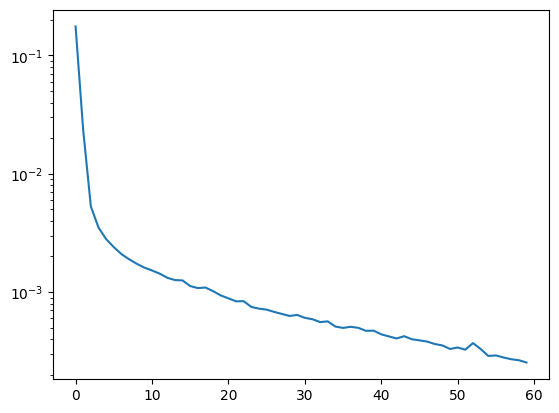

In [13]:
history = generator.fit(x_train,y_train,batch_size=64,epochs=60,validation_data=[x_val,y_val])
his = history.history['loss']
plt.semilogy(his)

# Evaluation

In [14]:
def rmse(a,b):
  return np.sqrt(np.mean((a-b)**2))

In [15]:
rec_val_data = generator(x_val)
print(rmse(rec_val_data,y_val))

rec_test_data = generator(x_test)
print(rmse(rec_test_data,y_test))
### Warum y???
# 0.08003962
# 0.074322596

0.014591673
0.0146224415


In [16]:
#round(x_test.shape[0]/2)

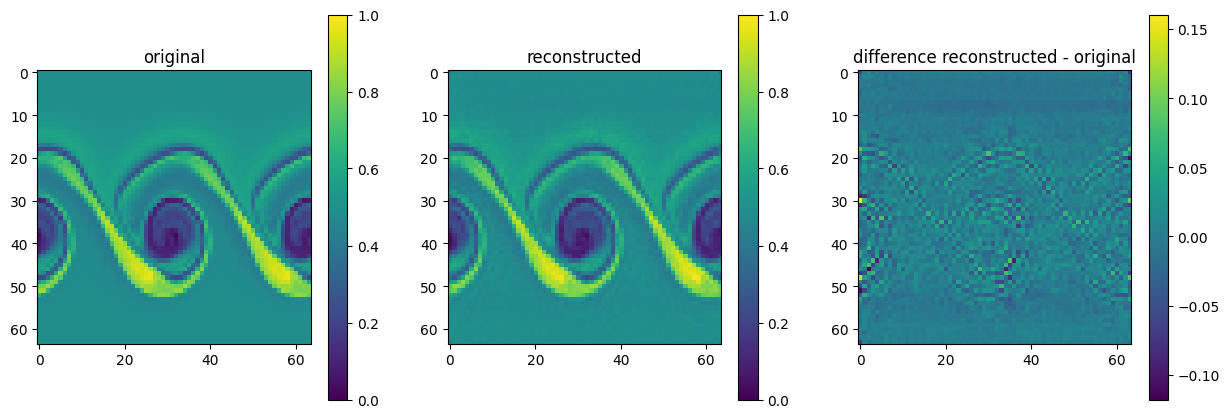

In [17]:
iid=7
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(y_test[iid,:,:,0], vmin=0, vmax=1)
plt.title('original')
plt.colorbar()

plt.subplot(132)
plt.imshow(rec_test_data[iid,:,:,0], vmin=0, vmax=1)
plt.title('reconstructed')
plt.colorbar()

plt.subplot(133)
plt.imshow(rec_test_data[iid,:,:,0]-y_test[iid,:,:,0]) #, cmap = 'seismic'
plt.title('difference reconstructed - original')
plt.colorbar()


In [18]:
dataset_noise=x_test+np.random.uniform(-0.3,0.3,x_test.shape)

# normalize data
dataset_x_noise =norm_train(dataset_noise,dataset_noise.min(),dataset_noise.max())
dataset_y_noise =norm_out(dataset_noise,dataset_noise.min(),dataset_noise.max())

rec_test_data_noise = generator(dataset_x_noise)
print(rmse(rec_test_data_noise, dataset_y_noise))



0.054322045


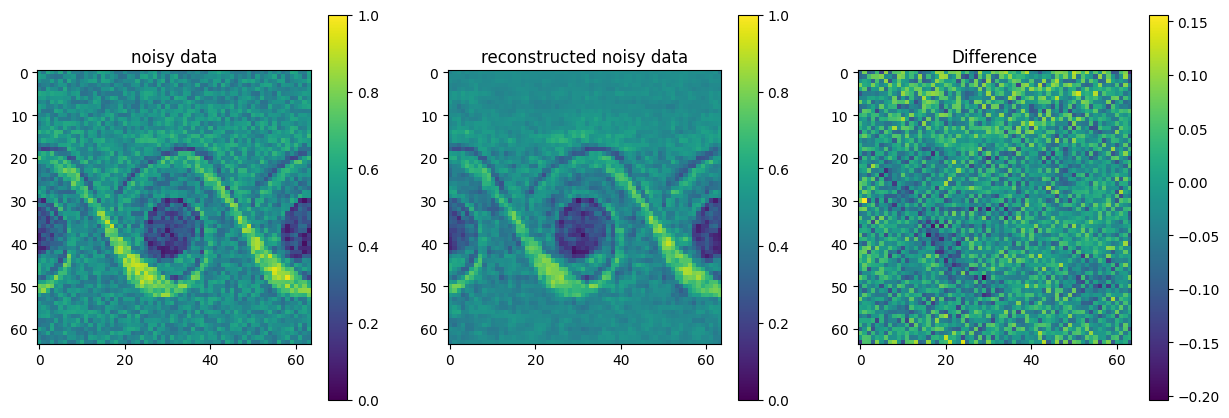

In [19]:
# iid=4
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(dataset_y_noise[iid,:,:,0], vmin=0, vmax=1)
plt.title('noisy data')
plt.colorbar()

plt.subplot(132)
plt.imshow(rec_test_data_noise[iid,:,:,0], vmin=0, vmax=1)
plt.title('reconstructed noisy data')
plt.colorbar()

plt.subplot(133)

plt.imshow(rec_test_data_noise[iid,:,:,0]-dataset_y_noise[iid,:,:,0]) #, cmap = 'seismic'
plt.title('difference reconstructed - original')

plt.title('Difference')
plt.colorbar()
